# Doordash Estimated Time of Arrival 
Mission: Predict the total delivery duration <br>
Meaning: From Customer Placing Order until it delivered

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
historical_data = pd.read_csv('historical_data.csv')
historical_data.head(5)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [12]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

Step 1, look at the data
1. Look at satuan (dollar, minutes, second)
2. Understand the Y actual on data set, in this case total delivery time from, actual_delivery_time - created_at because both are time stamp
3. Look at the data description from here we know that

Data Description
1. both onshift, busy dasher and outstanding orders are during created_at
2. estimated_order_place_duration -> Only from doordash until restaurance received 
3. estimated_store_to_consumer_driving_duration -> Only travel time
4. Thus we miss, TIME RESTAURANT PREPARING THE ORDER

We have
1. created_at -> Order placed
2. actual_delivery_time -> Order arrived
3. Y actual = actual_delivery_time - created_at -> (in second) why? because the time value for estimated are also in second
3. estimated_order_place_duration -> From order placed until accepted by store 
4. esimated_store_to_consumer_driving_duration -> From store received order, cooking time and delivery duration

In [13]:
# From the data, created_at and actual_delivery_time are in OBJECT despite the value is datetime
# Dollar value already in int, and all others are in float
# So convert to datetime
historical_data['created_at'] = pd.to_datetime(historical_data['created_at'])
historical_data['actual_delivery_time'] = pd.to_datetime(historical_data['actual_delivery_time'])

In [14]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   store_primary_category                        192668 non-null  object        
 5   order_protocol                                196433 non-null  float64       
 6   total_items                                   197428 non-null  int64         
 7   subtotal                                      197428 non-null  int64         
 8   num_distinct_items                            197428 n

# Feature Creation
Can we create better feature from existing one
1. Target value needs to be defined
2. Onshift and busy dasher are represented as number during order created time but ratio might be more relevant with, higher ratio means longer duration time
3. We can combine both the estimated order place and delivery time as non prepping duration, reducing information from 2 to 1 column

In [15]:
from datetime import datetime
# 1. Defined target value
historical_data['total_delivery_time'] = (historical_data['actual_delivery_time'] - historical_data['created_at']).dt.total_seconds()

# 2. Busy Ratio
historical_data['busy_ratio'] = (historical_data['total_busy_dashers'] / historical_data['total_onshift_dashers'])

# 3. Non Estimated Preparation time
historical_data['estimated_non_prep_duration'] = (historical_data['estimated_order_place_duration'] + historical_data['estimated_store_to_consumer_driving_duration'])

In [16]:
historical_data.head(2)
# Why does total_delivery_time is in days 0 days 01:02:59? not in second
# So its in time delta, can it be in second instead

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,busy_ratio,estimated_non_prep_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0


In [17]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 19 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   store_primary_category                        192668 non-null  object        
 5   order_protocol                                196433 non-null  float64       
 6   total_items                                   197428 non-null  int64         
 7   subtotal                                      197428 non-null  int64         
 8   num_distinct_items                            197428 n

# Data Modelling
1. One hot encode categorical data for regression, because in category 1 and 2 are two separate things, the numerical value of 1 and 2 and its closeness has no meaning to the category itself, thus its better to make each category a true false
2. Check the unique values
3. Categorical value are: store_id, order_protocol, market_id
4. Why not store_primary_category? There is still null values, we have to make it NaN Null first before one hot encode it

In [18]:
historical_data['market_id'].nunique()

6

In [19]:
historical_data['store_id'].nunique()

6743

In [20]:
historical_data['order_protocol'].nunique()

7

Conclusion:
1. We can one hot encode market_id and order_protocol
2. Using get dummies

In [21]:
market_id_dummies = pd.get_dummies(historical_data['market_id'])
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
197423,1,0,0,0,0,0
197424,1,0,0,0,0,0
197425,1,0,0,0,0,0
197426,1,0,0,0,0,0


In [22]:
order_protocol_dummies = pd.get_dummies(historical_data['order_protocol'])
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
197423,0,0,0,1,0,0,0
197424,0,0,0,1,0,0,0
197425,0,0,0,1,0,0,0
197426,1,0,0,0,0,0,0


In [23]:
# Checking if a NaN store_primary_category has a cateogry in another order
historical_data_test = historical_data[historical_data['store_id'] == 5477]
historical_data_test

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,busy_ratio,estimated_non_prep_duration
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0
5,3.0,2015-01-28 20:30:38,2015-01-28 21:08:58,5477,NaN,1.0,3,5000,3,1500,1900,2.0,2.0,2.0,446,338.0,2300.0,1.000000,784.0
6,3.0,2015-01-31 02:16:36,2015-01-31 02:43:00,5477,NaN,1.0,2,3900,2,1200,2700,10.0,9.0,9.0,446,638.0,1584.0,0.900000,1084.0
7,3.0,2015-02-12 03:03:35,2015-02-12 03:36:20,5477,NaN,1.0,4,4850,4,750,1800,7.0,8.0,7.0,446,626.0,1965.0,1.142857,1072.0
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,1586.0,0.750000,735.0
9,3.0,2015-02-18 01:15:45,2015-02-18 02:08:57,5477,NaN,1.0,2,2100,2,700,1200,2.0,2.0,2.0,446,715.0,3192.0,1.000000,1161.0
10,3.0,2015-02-02 19:22:53,2015-02-02 20:09:19,5477,NaN,4.0,4,4300,4,1200,1500,1.0,1.0,1.0,446,453.0,2786.0,1.000000,899.0


### Conclusion on analysis
NaN store_primary_category might have a category in different order, for example Mexican and Indian for order 1 and 8

### Action
Impute NaN value for each order based on the common category of that store using dictionary <br>
key is store_id, value is the common values

### Trial on getting the store_primary_category for a specific value

In [24]:
historical_data[historical_data['store_id'] == 5477].store_primary_category.mode()

0     indian
1    mexican
Name: store_primary_category, dtype: object

In [25]:
historical_data[historical_data.store_id == 5477].store_primary_category

1     mexican
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8      indian
9         NaN
10        NaN
11        NaN
12        NaN
13        NaN
Name: store_primary_category, dtype: object

In [26]:
# 1. Create list of unique stores
unique_store_id = historical_data['store_id'].unique().tolist()

# 2. Create the dictioanry
store_id_and_category = {store_id: historical_data[historical_data['store_id'] == store_id].store_primary_category.mode()
                         for store_id in unique_store_id}

In [27]:
store_id_and_category

{1845: 0    american
 Name: store_primary_category, dtype: object,
 5477: 0     indian
 1    mexican
 Name: store_primary_category, dtype: object,
 2841: 0    italian
 Name: store_primary_category, dtype: object,
 4139: 0    mexican
 Name: store_primary_category, dtype: object,
 5058: 0    italian
 Name: store_primary_category, dtype: object,
 4149: 0    sandwich
 1        thai
 Name: store_primary_category, dtype: object,
 3201: 0    cafe
 Name: store_primary_category, dtype: object,
 5054: 0    italian
 Name: store_primary_category, dtype: object,
 2004: 0    american
 Name: store_primary_category, dtype: object,
 1984: 0    chinese
 Name: store_primary_category, dtype: object,
 4905: 0    mexican
 Name: store_primary_category, dtype: object,
 1698: 0    sandwich
 Name: store_primary_category, dtype: object,
 1936: 0    singaporean
 Name: store_primary_category, dtype: object,
 6015: 0    burger
 Name: store_primary_category, dtype: object,
 976: 0    breakfast
 Name: store_primary_c

In [28]:
def fill_nan(store_id):
    """Return estimated primary store category from dictionary"""
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan

historical_data["non_nan_store_primary_category"] = historical_data['store_id'].apply(fill_nan)

In [29]:
# Checking imputation
historical_data[(historical_data['store_id'] == 5477) & (historical_data['store_primary_category'].isnull())].head(2)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,busy_ratio,estimated_non_prep_duration,non_nan_store_primary_category
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.0,1136.0,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.0,735.0,indian


In [30]:
# one hot encode that column
non_nan_store_primary_category_dummies = pd.get_dummies(historical_data['non_nan_store_primary_category'])
non_nan_store_primary_category_dummies = non_nan_store_primary_category_dummies.add_prefix('category_')
non_nan_store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
train_df = historical_data.drop(columns=["created_at", "actual_delivery_time","market_id", "order_protocol", "store_id","non_nan_store_primary_category","store_primary_category"])
train_df.head(5)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,busy_ratio,estimated_non_prep_duration
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0


In [32]:
train_df = pd.concat([train_df, non_nan_store_primary_category_dummies, order_protocol_dummies, market_id_dummies], axis = 1)
train_df.head(5)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,...,0,0,0,0,1,0,0,0,0,0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,...,0,0,0,0,0,1,0,0,0,0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,...,0,0,0,0,0,0,1,0,0,0
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,...,0,0,0,0,0,0,1,0,0,0
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,...,0,0,0,0,0,0,1,0,0,0


In [33]:
# Convert to float for model 
train_df = train_df.astype('float32')
train_df.head(5)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Check the value if any value is infinite, it will 
Note
1. Axis 0 is rows
2. Axis 1 is columms (thus we concat the dummies with train_df using column, because we want to concat the column)
3. Check infinite value
4. Replace them with NaN for easier removal


In [34]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,545.358948,...,0.098031,0.224335,0.004022,0.000096,0.192663,0.278876,0.118003,0.241095,0.091172,0.073191
std,2.665833,1822.968994,1.629398,522.068542,558.358337,34.524193,32.146065,52.657368,90.211159,219.350143,...,0.297521,0.417420,0.063310,0.009809,0.394420,0.448546,0.322467,0.428078,0.288200,0.260173
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
train_df['busy_ratio'].describe()

count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_ratio, dtype: float64

In [36]:
infinite_rows = np.where(np.any(~np.isfinite(train_df), axis=0) == True)
# ~np.isinfinite will NEGATE each column value
# Example 1 become FALSE because its TRUE as finite then we NEGATE it
# Then we filter in np.where using == True
infinite_rows

(array([ 5,  6,  7,  9, 10, 11, 12]),)

In [37]:
train_df.replace([np.inf, -np.inf], np.nan, inplace= True)
train_df.dropna(inplace=True)

In [38]:
# Sucessfully remove NaN Value and infinite value particularly for Busy Dasher
train_df['busy_ratio'].describe()

count    177070.000000
mean          0.949947
std           0.406551
min         -13.000000
25%           0.826923
50%           0.962264
75%           1.000000
max          31.000000
Name: busy_ratio, dtype: float64

In [39]:
train_df.shape
# Lots of column, can have detrimental effect

(177070, 100)

# Part 2 Removing Collinearity
1. Collinearity reduces model interpretability (becaused we don't know which feature affecting the outcome if 2 or more have high coefficient)
2. Using heatmap, we can visualize correlation
3. Ordering the correlation value, we can feature engineered highly correlated feature

## 2.1 Heatmap

In [40]:
# Creating correlation heatmap of 100*100
# But we remove the redudant triangle using mask
corr = train_df.corr()

In [41]:
# Creating mask using np ones
# Initially we create 2d array with the same shape as corr matrix

# np.triu allows to create 0 for the lower left triangle
mask = np.triu(np.ones_like(corr, dtype=bool))


<Axes: >

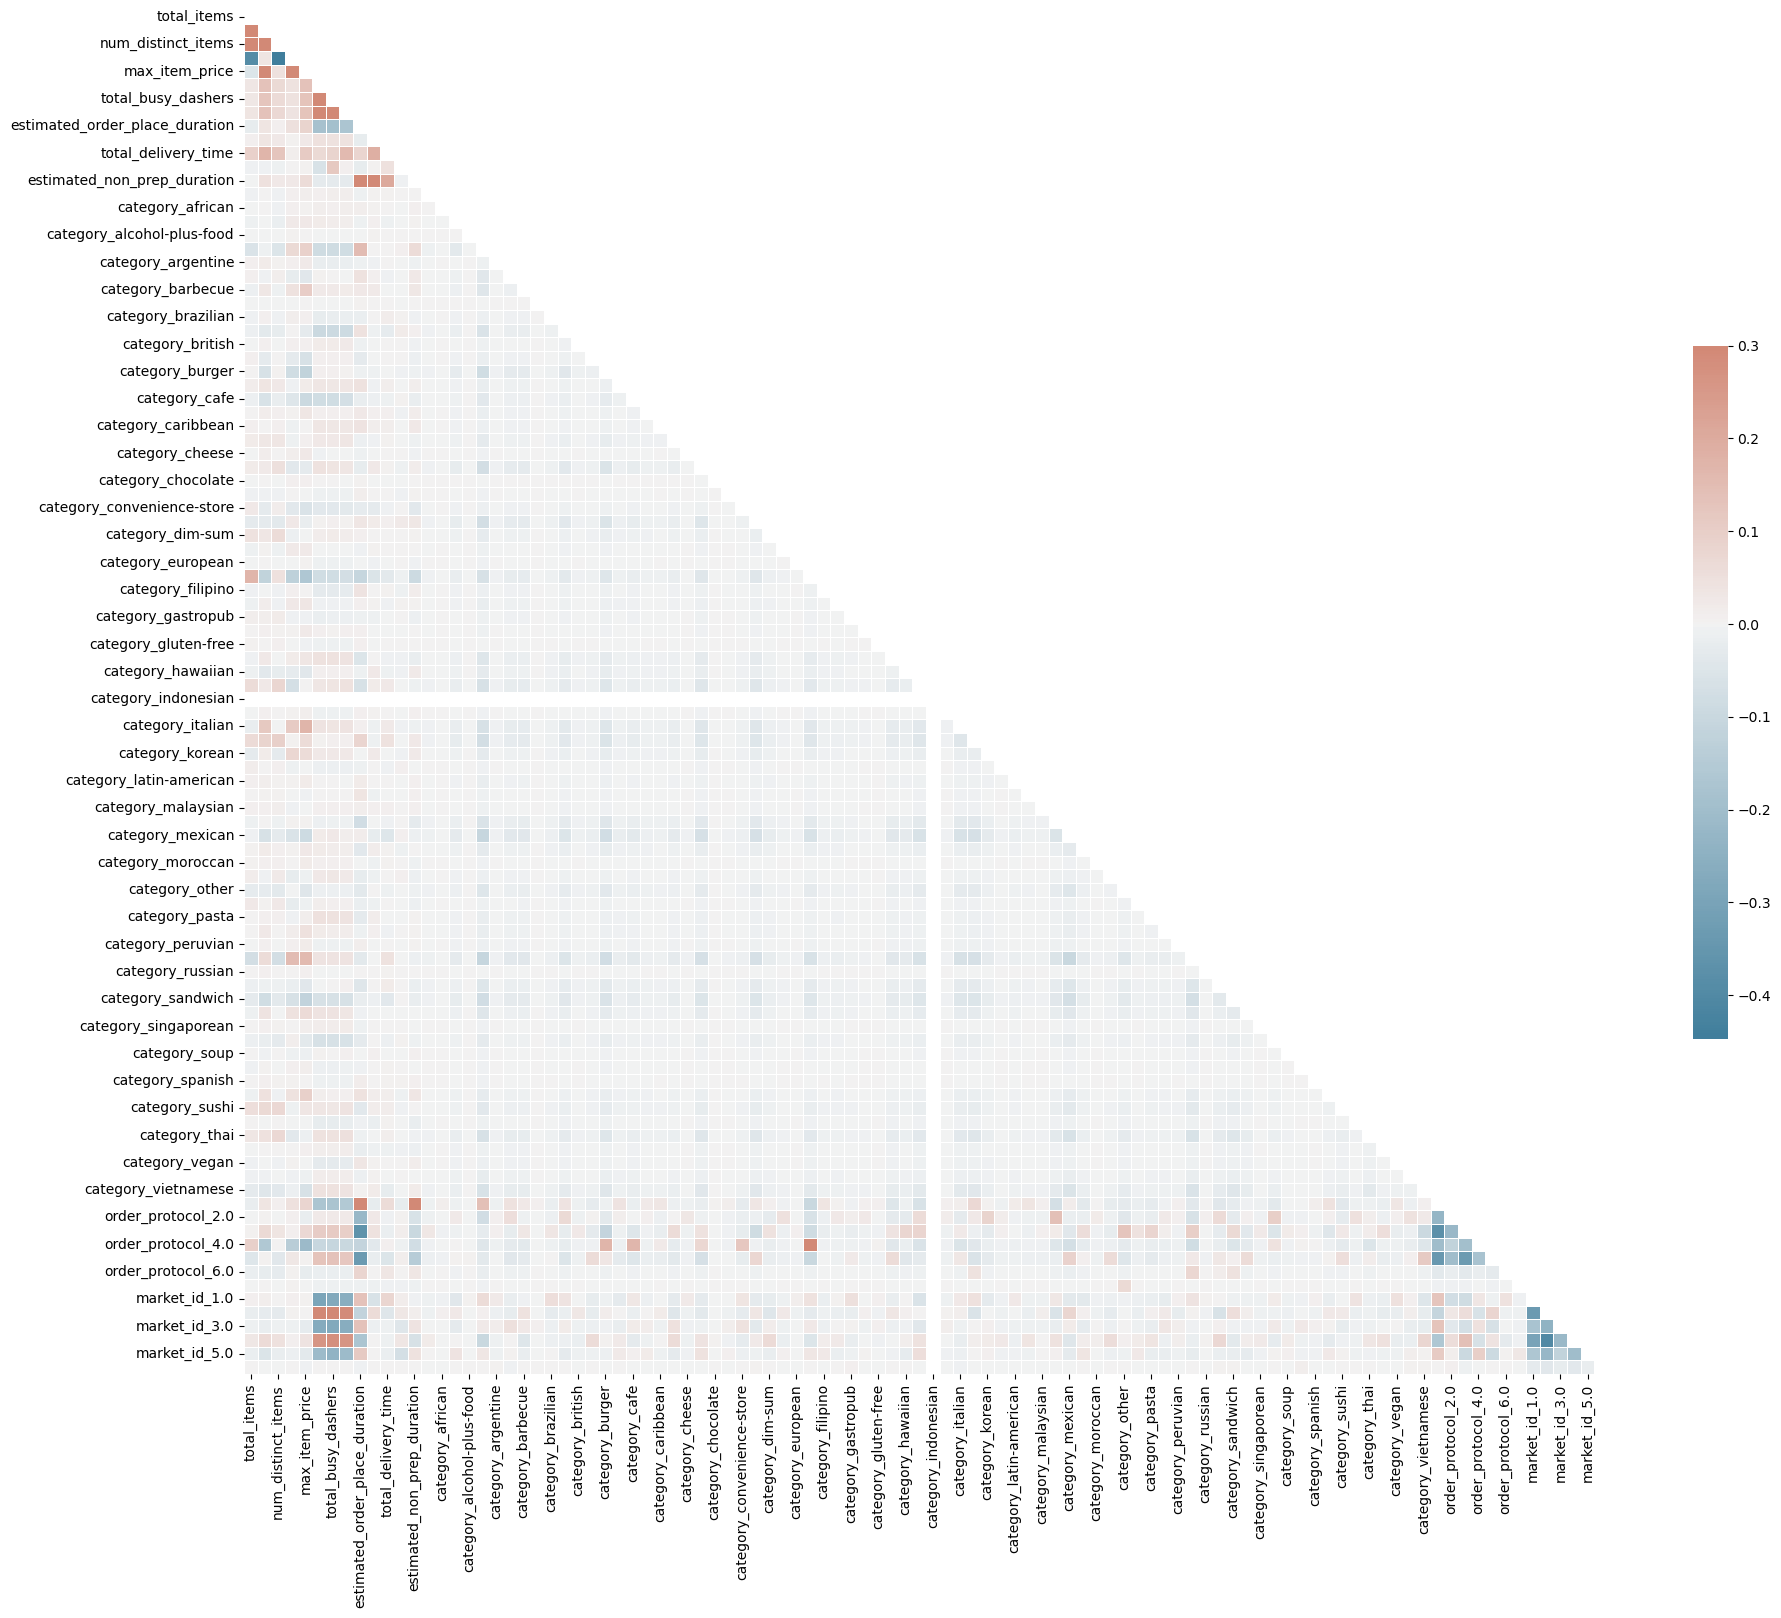

In [42]:
# Plot the heatmap
f, ax = plt.subplots(figsize=(22,18))

# Create colour map, since we have both positive and negative value, we are using diverging pallete
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Create heatmap with correlation
sns.heatmap(data=corr, mask=mask, cmap=cmap,
            vmax=0.3, center=0, square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})

In [43]:
# From the map we can see category indonesian has no value
train_df['category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

## 2.2 Remove correlation through feature engineering
1. Function to
2. Function to get the highest correlation

In [44]:
def get_redundant_pairs(df):
    """Get the lower triangle pairs of attribute, thus removing the redunant pair
      a     b       c
    a a,a
    b b,a   b,b 
    c c,a   c,b     c,c
    """
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [45]:
train_df.corr().abs().unstack()
# Unstack will separate from 100,100 into 10000
# abs will make the negative into positive

total_items    total_items           1.000000
               subtotal              0.557175
               num_distinct_items    0.758146
               min_item_price        0.389277
               max_item_price        0.052845
                                       ...   
market_id_6.0  market_id_2.0         0.040269
               market_id_3.0         0.021746
               market_id_4.0         0.036364
               market_id_5.0         0.020186
               market_id_6.0         1.000000
Length: 10000, dtype: float64

In [46]:
def get_top_abs_correlations(df, n=5):
    """Sore correlation in descending order and return the n highest results"""
    mod_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    sorted_corr = mod_corr.drop(labels=labels_to_drop).sort_values(ascending= False)
    return sorted_corr[0:n]

In [47]:
print("Top Absolute Correlation")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlation
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
category_fast                                 order_protocol_4.0             0.489946
num_distinct_items           

## What we can learn from here
1. Both onshift and busy dasher are both highly correlated, additionally we have use busy dasher ratio, thus we can remove both
2. store to consumer and on prep duration are highly correlated, so we can remove the non_prep_duration and maintain the original one
3. Market id are correlated with one another, marker_id_2.0 and marker_id_4.0 and market_id 1 with 2, thus we don't need to combine the dummy variable
4. Removing category indonesian as it has no values

In [48]:
# Removing engineered feature and one_hot_encoding original feature
train_df = historical_data.drop(columns=["created_at", "actual_delivery_time","market_id", "order_protocol", "store_id","non_nan_store_primary_category","store_primary_category"])

# Concatenate the dummies without the market_id
train_df = pd.concat([train_df, non_nan_store_primary_category_dummies, order_protocol_dummies], axis = 1)

# Drop values based on the heatmap and correlation results
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers", "estimated_non_prep_duration", "category_indonesian"])

In [49]:
# Change the value type to float and then remove the infinite value
infinite_rows = np.where(np.any(~np.isfinite(train_df), axis=0) == True)
infinite_rows
train_df.replace([np.inf, -np.inf], np.nan, inplace= True)
train_df.dropna(inplace=True)

# Change the datatype
train_df.astype('float32')

train_df.head(5)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,busy_ratio,...,category_vegan,category_vegetarian,category_vietnamese,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,4,3441,4,557,1239,21.0,446,861.0,3779.0,0.424242,...,0,0,0,1,0,0,0,0,0,0
1,1,1900,1,1400,1400,2.0,446,690.0,4024.0,2.000000,...,0,0,0,0,1,0,0,0,0,0
2,1,1900,1,1900,1900,0.0,446,690.0,1781.0,0.000000,...,0,0,0,1,0,0,0,0,0,0
3,6,6900,5,600,1800,2.0,446,289.0,3075.0,1.000000,...,0,0,0,1,0,0,0,0,0,0
4,3,3900,3,1100,1600,9.0,446,650.0,2390.0,1.000000,...,0,0,0,1,0,0,0,0,0,0


In [50]:
print("Top Absolute Correlation")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlation
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
category_fast                   order_protocol_4.0    0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duration

## Conclusion
1. We can see that order_protocol are highly correlated so we can just remove it

In [51]:
# Removing engineered feature and one_hot_encoding original feature
train_df = historical_data.drop(columns=["created_at", "actual_delivery_time","market_id", "order_protocol", "store_id","non_nan_store_primary_category","store_primary_category"])

# Concatenate the dummies without the market_id
train_df = pd.concat([train_df, non_nan_store_primary_category_dummies], axis = 1)

# Drop values based on the heatmap and correlation results
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers", "estimated_non_prep_duration", "category_indonesian"])

# Change the value type to float and then remove the infinite value
train_df.replace([np.inf, -np.inf], np.nan, inplace= True)
train_df.dropna(inplace=True)

# Change the datatype
train_df.astype('float32')

train_df.head(5)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,busy_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4,3441,4,557,1239,21.0,446,861.0,3779.0,0.424242,...,0,0,0,0,0,0,0,0,0,0
1,1,1900,1,1400,1400,2.0,446,690.0,4024.0,2.000000,...,0,0,0,0,0,0,0,0,0,0
2,1,1900,1,1900,1900,0.0,446,690.0,1781.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,6,6900,5,600,1800,2.0,446,289.0,3075.0,1.000000,...,0,0,0,0,0,0,0,0,0,0
4,3,3900,3,1100,1600,9.0,446,650.0,2390.0,1.000000,...,0,0,0,0,0,0,0,0,0,0


In [52]:
print("Top Absolute Correlation")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlation
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  total_delivery_time               0.188418
subtotal                                      total_delivery_time               0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170

### Conclusion
We still have highly correlated item but we can try to reduce it into 1 values 
1. total_items and subtotal item are correlated, so we can combine by subtotal/total_items giving us the average price of items
2. max_item_price and min_item_price is correlated, thus we can subtract max with min to get the price difference
3. We don't remove total_items, we just remove one of the variable that has high correlation <br>
for example sub_total and total, we combine both variable subtotal and total_item, and KEPT TOTAL_ITEMs

In [53]:
# Feature engineering
train_df['avg_price_per_item'] = train_df['subtotal'] / train_df['total_items']
train_df['percent_distinct_item_from_total'] = train_df['num_distinct_items'] / train_df['total_items']

train_df.drop(columns=['subtotal', 'num_distinct_items'], inplace=True)

In [54]:
print("Top Absolute Correlation")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlation
min_item_price                                avg_price_per_item                  0.860580
max_item_price                                avg_price_per_item                  0.770382
min_item_price                                max_item_price                      0.541241
total_items                                   percent_distinct_item_from_total    0.445751
                                              min_item_price                      0.389277
                                              avg_price_per_item                  0.310759
avg_price_per_item                            percent_distinct_item_from_total    0.226711
category_pizza                                avg_price_per_item                  0.225510
estimated_store_to_consumer_driving_duration  total_delivery_time                 0.188418
max_item_price                                percent_distinct_item_from_total    0.178021
category_fast                                 avg_price_per_item 

In [55]:
train_df['price_range_max_to_min'] = train_df['max_item_price'] - train_df['min_item_price']
train_df.drop(columns=['max_item_price', 'min_item_price'], inplace=True)

In [56]:
print("Top Absolute Correlation")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlation
total_items                                   percent_distinct_item_from_total    0.445751
                                              price_range_max_to_min              0.333304
                                              avg_price_per_item                  0.310759
avg_price_per_item                            percent_distinct_item_from_total    0.226711
category_pizza                                avg_price_per_item                  0.225510
estimated_store_to_consumer_driving_duration  total_delivery_time                 0.188418
category_fast                                 avg_price_per_item                  0.175950
total_outstanding_orders                      estimated_order_place_duration      0.171049
total_items                                   category_fast                       0.170988
category_italian                              avg_price_per_item                  0.158193
total_outstanding_orders                      total_delivery_time

In [57]:
train_df.shape

(177070, 82)

# 3. Removing Multicolinearity and Dimension
1. Multicolinearity is when multiple attribute correlate with one to another
2. We can reduce dimension and multimple colinearity through PCA(Optimum attribute to get high variance) or Random Forest Regression(Which feature has high gini importance)

## 3.1 Calculate Multicolinearity using VIF
1. Multiplecolinearity happend when more than 2 variable correlate with each other
2. It makes regression model harder to interpret
3. We quantify MultiColinearity with VIF (it measure how much regression analysis effected by colinearity)
4. We remove variable with score above 20

In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(features):
    """Compute and sort VIF for each features"""
    vif_data = pd.DataFrame()
    vif_data['feature'] = features
    vif_data['VIF'] = [variance_inflation_factor(train_df[features].values,i) for i in range(len(features))]
        # We put all features, and specify particular feature index such as 0 or 1, that we want to compare with all other features in VIF
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

In [59]:
# Apply function to all columns beside the output
features = train_df.drop(columns=['total_delivery_time']).columns.to_list()
vif_results = compute_vif(features)
vif_results


,feature,VIF
0,category_alcohol-plus-food,1.000369
1,category_chocolate,1.000488
2,category_belgian,1.000749
3,category_russian,1.003225
4,category_african,1.003820
...,...,...
76,busy_ratio,6.369592
77,category_american,7.033601
78,estimated_store_to_consumer_driving_duration,7.210812
79,estimated_order_place_duration,13.472106


## 3.2 Drop the VIF Score if its above 20 using while loop

In [60]:
multicolinearity = True

while multicolinearity:
    highest_vif_features = vif_results['feature'].tolist()[-1]
    print("I will remove",highest_vif_features )
    features.remove(highest_vif_features)
    vif_results = compute_vif(features)
    multicolinearity = False if len(vif_results[vif_results.VIF > 20]) == 0 else True 

selected_features = vif_results['feature'].to_list()

I will remove percent_distinct_item_from_total


In [61]:
vif_results

,feature,VIF
0,category_alcohol-plus-food,1.000221
1,category_chocolate,1.000361
2,category_belgian,1.000451
3,category_russian,1.002016
4,category_gluten-free,1.002363
...,...,...
75,category_american,4.505927
76,avg_price_per_item,5.958952
77,busy_ratio,6.357882
78,estimated_store_to_consumer_driving_duration,7.192612


## 3.3 Feature Selection using PCA and Random Forrest Regression
1. Reducing dimentionality based on importance features

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [63]:
X = train_df[selected_features]
y = train_df['total_delivery_time']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### 3.3.1 Using Gini Importancr
1. Random Forest calculate gini importance for each feature by how well it splits the data 

In [64]:
feature_names = [f"features {i}" for i in range((X.shape[1]))]
# This will format string into feature 0, feature 1
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feats = {} # Dictionary to hold feature name: feature_importance
    # Extract the gini importance from each feature in the forest
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance

In [65]:
feats

{'category_alcohol-plus-food': 2.2689820660684665e-07,
 'category_chocolate': 3.558513769768279e-07,
 'category_belgian': 1.432675638834066e-07,
 'category_russian': 2.557240415443916e-05,
 'category_gluten-free': 1.5258059783148169e-05,
 'category_african': 2.2941350142332775e-06,
 'category_european': 3.547249249598156e-05,
 'category_comfort-food': 0.00021020996838072516,
 'category_spanish': 5.4521728135597134e-05,
 'category_cheese': 5.6130321827976404e-05,
 'category_moroccan': 4.077595252584799e-05,
 'category_singaporean': 1.8593563101291486e-05,
 'category_southern': 0.000221318655342101,
 'category_kosher': 4.4440812416709455e-05,
 'category_soup': 0.00014181413775695396,
 'category_irish': 4.037072725373018e-05,
 'category_argentine': 8.202746971958027e-05,
 'category_german': 2.366893482916692e-05,
 'category_tapas': 0.0006309759933674476,
 'category_afghan': 0.0009564924299552159,
 'category_malaysian': 0.00022678097338502964,
 'category_pakistani': 0.00012876084015836013,

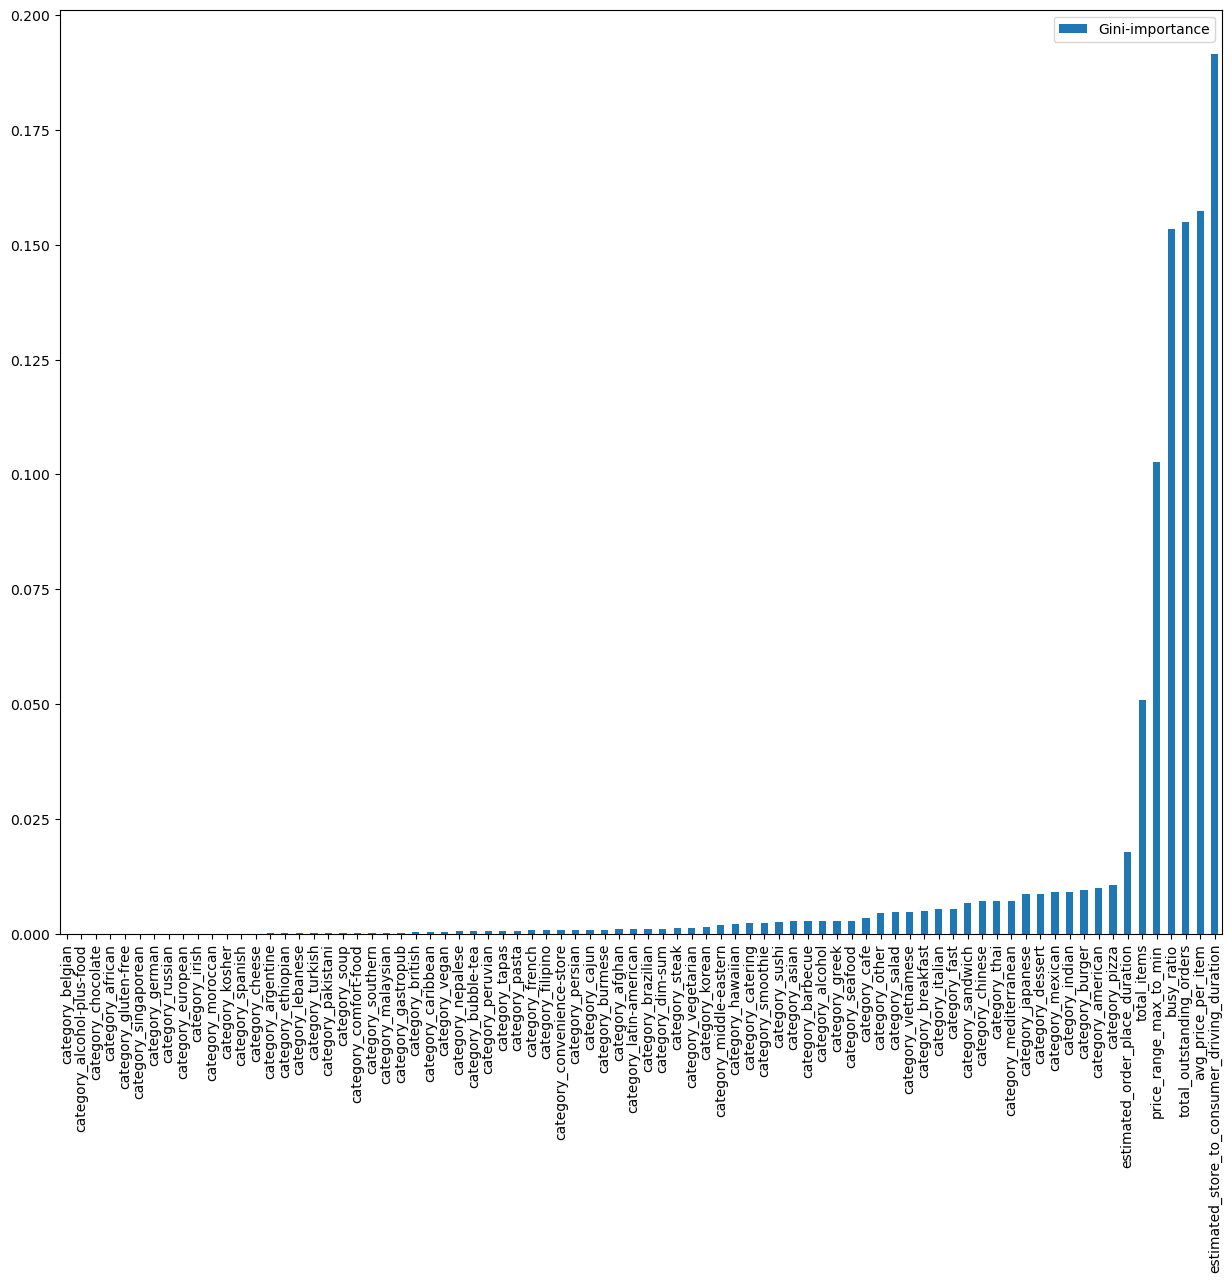

In [66]:
# Change from dict to dataframe, for easier visualization
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

In [67]:
importances.sort_values(by='Gini-importance')[-35:].index.tolist()

['category_middle-eastern',
 'category_hawaiian',
 'category_catering',
 'category_smoothie',
 'category_sushi',
 'category_asian',
 'category_barbecue',
 'category_alcohol',
 'category_greek',
 'category_seafood',
 'category_cafe',
 'category_other',
 'category_salad',
 'category_vietnamese',
 'category_breakfast',
 'category_italian',
 'category_fast',
 'category_sandwich',
 'category_chinese',
 'category_thai',
 'category_mediterranean',
 'category_japanese',
 'category_dessert',
 'category_mexican',
 'category_indian',
 'category_burger',
 'category_american',
 'category_pizza',
 'estimated_order_place_duration',
 'total_items',
 'price_range_max_to_min',
 'busy_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

### 3.3.2 Using PCA
1. To find out the optimum number of feature to explain our data

In [68]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_train = X_train.values
X_train = np.asarray(X_train)
# We scaled the x trained for easier fit
X_std = StandardScaler().fit_transform(X_train)
pca = PCA().fit(X_std)

In [69]:
pca.explained_variance_ratio_

array([2.10140843e-02, 1.86481624e-02, 1.72797452e-02, 1.43996700e-02,
       1.38373080e-02, 1.34943426e-02, 1.33870684e-02, 1.32951867e-02,
       1.32301311e-02, 1.31653657e-02, 1.31193934e-02, 1.30209292e-02,
       1.29744535e-02, 1.29542425e-02, 1.29097523e-02, 1.28467547e-02,
       1.28274967e-02, 1.27592902e-02, 1.27495178e-02, 1.27353755e-02,
       1.27184923e-02, 1.26943763e-02, 1.26813759e-02, 1.26648623e-02,
       1.26407840e-02, 1.26314054e-02, 1.26224075e-02, 1.26174478e-02,
       1.26111376e-02, 1.25997691e-02, 1.25884511e-02, 1.25683238e-02,
       1.25661415e-02, 1.25579923e-02, 1.25535720e-02, 1.25502162e-02,
       1.25425293e-02, 1.25392236e-02, 1.25379963e-02, 1.25305427e-02,
       1.25299618e-02, 1.25261657e-02, 1.25225623e-02, 1.25199310e-02,
       1.25188560e-02, 1.25170754e-02, 1.25149851e-02, 1.25141132e-02,
       1.25128871e-02, 1.25107555e-02, 1.25106508e-02, 1.25094728e-02,
       1.25087707e-02, 1.25075075e-02, 1.25074329e-02, 1.25067497e-02,
      

#### Process PCA results
1. Above are PCA results
2. We want to plot it progressively based on each feature to see incremental trend of pca using cumsum (cumulative sum)

/var/folders/bn/5csnhvg56592bvs653v05pyw0000gn/T/ipykernel_49673/254633027.py:2: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,81,1)


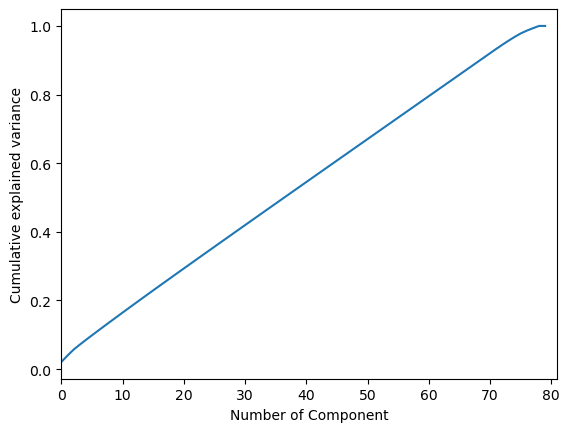

In [70]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel("Number of Component")
plt.ylabel('Cumulative explained variance')
plt.show()

#### PCA Conclusion
1. 60 features will explain 80% of our dataframe
2. Currently we have 80 Feature which is fine at explaining 100%
3. If we have 10-20 feature to explain 80% then we can remove the redundant feature based on gini importance sort

### 3.3 Scaling
1. Applying scaler for easier model processing
2. Using either StandardScaler or MinMaxScaler
3. Implemented through custom function

In [71]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [72]:
def scale(scaler, X, y):
    """Apply the selected scaler to features and target variables"""
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
        # Reshape will change the original array into 2D array of (n,1)
            # n is number of element in the original array
                # same row but with 1 column
                    # because y target value are in multiple row for each delivery
    y_scaler.fit(y.values.reshape(-1,1))
    y_scaled = y_scaler.transform(y.values.reshape(-1,1))
    return X_scaled, y_scaled, X_scaler, y_scaler

In [73]:
# Applying the scaler
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

In [74]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, random_state=42, test_size=0.2
)

### 3.4 Inverse Scaling to check prediction
1. Because we scaled the input using x_train_scaled and y_train_scaled, we get a scaled results of y_predict
2. To be able to compared and evaluate y_predict from scaled input, into y_test
3. We need to inverse back the y_predict to its original state
4. Then compare with y_test

In [105]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    # return RMSE with squared False     
    rmse_error = mean_squared_error(y_test, y_predict[:,0], squared=False)
    print("Error = "'{}'.format(rmse_error)+" in " + model_name)
    
    return rmse_error, y_predict

# 4. Implement Machine Learning Technique for Model Performance
We will implement
1. 6 different algorithm
2. 4 different feature set selection (Full, 40, 20, 10)
3. 3 different scaler (MinMax, Standard, NoScale)
Final results is 72 different combination

In [98]:
# Import libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree, svm, neighbors, linear_model

#### 4.1 Create regression function that we can call again
1. It can take any model
2. It fit the model and make prediction on both training and test
3. It outputed the model, prediction, train error and test error

In [99]:
# Create Function that we can call again
    # Verbose the amount outputed on the training log
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    model.fit(X_train,y_train)
    y_predict=model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)
    y_predict = model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict, squared=False)
    if verbose:
        print("Train error = "'{}'.format(train_error)+" in " + model_name)
        print("Test error = "'{}'.format(test_error)+" in " + model_name)
    trained_model = model
    
    return trained_model, y_predict, train_error, test_error

In [100]:
# Storing each prediction results

pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": []
}

In [107]:
# Defining each regression model to be called later
regression_models = {
    "Ridge" : linear_model.Ridge(),
    "DecisionTree": tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP": MLPRegressor()
}

In [102]:
# Difference sets of features
feature_sets = {
    "full dataset": X.columns.to_list(),
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
    "selected_features_20": importances.sort_values(by='Gini-importance')[-20:].index.tolist(),
    "selected_features_10": importances.sort_values(by='Gini-importance')[-10:].index.tolist()
}

In [103]:
# Scaler
scalers = {
    "Standard Scaler": StandardScaler(),
    "MinMax Scaler": MinMaxScaler(),
    "NotScale": None
}

## 4.1 Calculating Prediction using all the difference variety
1. 3 For loop, 1 for feature sets, 2 for scaler, 3 for model
2. If-Else block on the inner loop, if we use a scaler, we must inverse transform the y_prediction to calculate the RMSE, otherwise we can do it directly

In [109]:
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():   
            if scaler_name == "NotScale":
                X = train_df[feature_set]
                y = train_df["total_delivery_time"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)
            
            else:
                
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                    X_scaled, y_scaled, test_size=0.2, random_state=42)
                # [:,0] means [first_row:last_row, column_0] it gives all values in column_0 if its a 2D matrix
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)

            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard Scaler-------- included columns are full dataset

Error = 2053.6985497900873 in Ridge
Error = 2057.2476684096064 in DecisionTree
Error = 2048.603398517993 in RandomForest
Error = 2035.786657077656 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 70
[LightGBM] [Info] Start training from score -0.002379
Error = 2033.4355810723252 in LGBM
Error = 2038.3511690043704 in MLP
-----scaled with MinMax Scaler-------- included columns are full dataset

Error = 2053.964732287661 in Ridge
Error = 2057.2476684096064 in DecisionTree
Error = 2049.074959326572 in RandomForest
Error = 2035.8851698255367 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading,

/Users/tobiassilalahi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1054.3268440681286 in MLP
Test error = 2046.8489418625593 in MLP
-----scaled with Standard Scaler-------- included columns are selected_features_40

Error = 2054.004202911205 in Ridge
Error = 2056.529202224364 in DecisionTree
Error = 2049.250089173532 in RandomForest
Error = 2036.0936306598262 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1447
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 40
[LightGBM] [Info] Start training from score -0.002379
Error = 2034.6538984599247 in LGBM
Error = 2036.3557022358623 in MLP
-----scaled with MinMax Scaler-------- included columns are selected_features_40

Error = 2054.2792548237862 in Ridge
Error = 2056.529202224364 in DecisionTree
Error = 2048.831602258748 in RandomForest
E

/Users/tobiassilalahi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1058.419067771547 in MLP
Test error = 2050.164765302732 in MLP
-----scaled with Standard Scaler-------- included columns are selected_features_10

Error = 2056.5683585920706 in Ridge
Error = 2054.597176140608 in DecisionTree
Error = 2052.0689053893766 in RandomForest
Error = 2038.406688199901 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1357
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 10
[LightGBM] [Info] Start training from score -0.002379
Error = 2038.13136041913 in LGBM
Error = 2039.9082173224547 in MLP
-----scaled with MinMax Scaler-------- included columns are selected_features_10

Error = 2056.8838657821448 in Ridge
Error = 2054.597176140608 in DecisionTree
Error = 2051.5861872367464 in RandomForest
Err

### 4.2 Analyze the results and improve it

In [110]:
pred_df = pd.DataFrame(pred_dict)
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full dataset,Standard Scaler,2053.698550
1,Ridge,full dataset,Standard Scaler,2053.698550
2,Ridge,full dataset,Standard Scaler,2053.698550
3,DecisionTree,full dataset,Standard Scaler,2057.247668
4,RandomForest,full dataset,Standard Scaler,2048.449788
...,...,...,...,...
81,DecisionTree,selected_features_10,NotScale,2065.989907
82,RandomForest,selected_features_10,NotScale,2065.989907
83,XGBoost,selected_features_10,NotScale,2065.989907
84,LGBM,selected_features_10,NotScale,2065.989907


<Axes: >

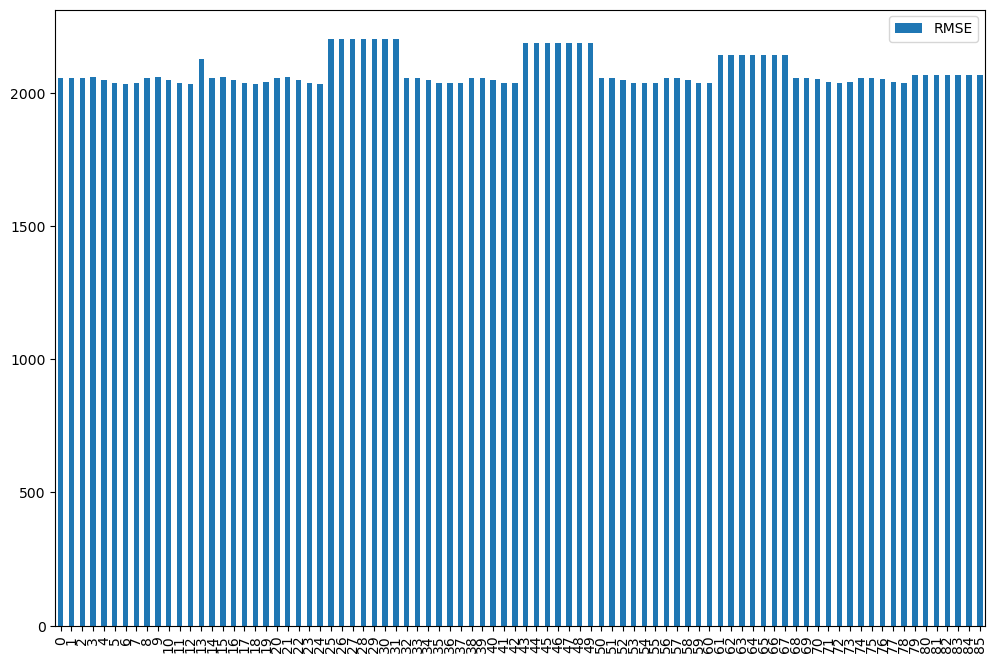

In [111]:
pred_df.plot(kind='bar', figsize=(12,8))

1. High errors throughout our models
2. Not Scaling makes out model a bit worse (thus we use scaling)
We use both to further improve out models

### 4.3 Changing the angle
1. Rather than calculating total delivery time, we calculate the prep_duration
2. we know that the formula is total_delivery = order received in restaurant + restaurant prep duration + driving from restaurant to consumer
3. Our target changes to 'restaurant prep duration' = total delivery time - order received in restaurant + driving time
4. We need to also from both order_recevied and driving_time to minimize multiplecollinearity

In [112]:
train_df["prep_time"] = train_df["total_delivery_time"] - train_df["estimated_store_to_consumer_driving_duration"] - train_df["estimated_order_place_duration"]
scalers = {
    "Standard Scaler": StandardScaler()
}
feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist()
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])  
            y = train_df["prep_time"] 

            # We split it 1st time to get the indices before being scaled

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # We split it 2nd time after being scaled

            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)


-----scaled with Standard Scaler-------- included columns are selected_features_40

Error = 2055.4075229887653 in Ridge
Error = 2045.9600605603337 in DecisionTree
Error = 2050.2185285710198 in RandomForest
Error = 2037.137682993206 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 38
[LightGBM] [Info] Start training from score -0.002301
Error = 2035.7236370513838 in LGBM
Error = 2038.8246418227584 in MLP


### 4.4. LGBM Model perform the best, so we repeat using only LGBM Model

In [113]:
train_df["prep_time"] = train_df["total_delivery_time"] - train_df["estimated_store_to_consumer_driving_duration"] - train_df["estimated_order_place_duration"]
scalers = {
    "Standard Scaler": StandardScaler()
}
feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist()
}

regression_models = {
    "LGBM" : LGBMRegressor()
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])  
            y = train_df["prep_time"] 
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)


-----scaled with Standard Scaler-------- included columns are selected_features_40

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 38
[LightGBM] [Info] Start training from score -0.002301
Error = 2035.7236370513838 in LGBM


### 4.5 Why do we need the indices
1. So we can match it with the actual values in the train_df
2. We will have the prediction in 'y_predict', now we will use it to embedded in a dataframe (combine the prediction with the appropriate delivery row)
3. We need test_indices to get which ROW IS USED AS THE TEST DATA

In [116]:
pred_values_dict = {
    "actual_total_delivery_duration" : train_df["total_delivery_time"][test_indices].values.tolist(),
    "prep_duration_prediction": y_predict[:,0].tolist(),
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration": train_df["estimated_order_place_duration"][test_indices].values.tolist(),             
}

In [117]:
# Convert it to dataframe for easier view
values_df = pd.DataFrame(pred_values_dict)
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,1734.115287,380.0,251
1,1839.0,1508.588146,747.0,446
2,1927.0,2141.085685,543.0,251
3,2657.0,1312.559865,445.0,251
4,3596.0,1945.871827,691.0,446
...,...,...,...,...
35409,9557.0,2623.132706,768.0,446
35410,1864.0,2148.159250,324.0,446
35411,2674.0,1939.286320,791.0,251
35412,2234.0,1930.656157,687.0,251


In [118]:
# Because we want to compared out prediction delivery time with actual delivery time
# We need to add prep duration + order to restaurant + driving duration
values_df["sum_total_delivery_duration"] = values_df["estimated_store_to_consumer_driving_duration"] + values_df["prep_duration_prediction"] + values_df["estimated_order_place_duration"]
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2448.0,1734.115287,380.0,251,2365.115287
1,1839.0,1508.588146,747.0,446,2701.588146
2,1927.0,2141.085685,543.0,251,2935.085685
3,2657.0,1312.559865,445.0,251,2008.559865
4,3596.0,1945.871827,691.0,446,3082.871827
...,...,...,...,...,...
35409,9557.0,2623.132706,768.0,446,3837.132706
35410,1864.0,2148.159250,324.0,446,2918.159250
35411,2674.0,1939.286320,791.0,251,2981.286320
35412,2234.0,1930.656157,687.0,251,2868.656157


## 4.6 Calculate the final mean square error based on these values

In [119]:
mean_squared_error(values_df["sum_total_delivery_duration"], values_df["actual_total_delivery_duration"], squared = False)

2035.7236370513838

We can see that the level of error is still high, so we need to change frame
1. In order to improve accuracy, we use our previous prediction to make further prediction
2. We use prep_duration_prediction along with ommited attributes
3. Essentially condensing the 80 variables into prep_duration_prediction
4. Then using it with the ommited attribues of estimated_store_to_consumer_duration and estimated_store_to_consumer_driving_duration

In [120]:
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df[["actual_total_delivery_duration"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


We are now directly applying the model because
1. Values are already in the same scaled (seconds)
2. Features are already at maximum of 3 features

In [121]:
# We are now directly applying the model because
regression_models = {
    "LinearReg" : linear_model.LinearRegression(),
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
}
for model_name in regression_models.keys():
    _, y_predict, _, _= make_regression(
        X_train, y_train, X_test, y_test,regression_models[model_name], model_name, verbose=False)
    print("RMSE of:",model_name, mean_squared_error(y_test,y_predict, squared=False))

RMSE of: LinearReg 986.6912510221224
RMSE of: Ridge 986.6912510262308
RMSE of: DecisionTree 1235.578088153976


/var/folders/bn/5csnhvg56592bvs653v05pyw0000gn/T/ipykernel_49673/649935514.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


RMSE of: RandomForest 1315.7074229036732
RMSE of: XGBoost 1034.7085905354322
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 28331, number of used features: 3
[LightGBM] [Info] Start training from score 2869.174261
RMSE of: LGBM 1079.2949179771774


/Users/tobiassilalahi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE of: MLP 987.8863918990169


The performance dropped by half, so this can be ourfinal solution

# 6. Using Deep Learning
1. We might have better results using deep learning so we can implement simple sequential model

In [129]:
!pip install keras
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.6/252.6 MB 2.2 MB/s eta 0:00:0000:0100:02
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.6.0-py3-none-any.whl (21 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl (25.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 kB 4.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 3.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 4.0 MB/s eta 0:00:0000:0100:01
  Using cached tensorflow_io_gcs_filesystem-0.37.1-cp311-cp311-macosx_12_0_arm64.whl (3.5 MB)
  Using cached tensorboard_data_server-0

In [130]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(42)

def create_model(feature_set_size):
    
    model = Sequential()
    model.add(Dense(16, input_dim = feature_set_size), activation = 'relu')
    model.add(Dense(1, activation = 'linear'))

    model.compile(optimizer='sgd', loss='mse', metrics = [tf.keras.metrics.RootMeanSquaredError()])

    return model


/Users/tobiassilalahi/anaconda3/lib/python3.11/site-packages/numpy/_core/_dtype.py:106: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if dtype.type == np.bool:


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/tobiassilalahi/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/bn/5csnhvg56592bvs653v05pyw0000gn/T/ipykernel_49673/2510316087.py", line 1, in <module>
    import keras
  File "/Users/tobiassilalahi/anaconda3/lib/python3.11/site-packages/keras/__init__.py", line 2, in <module>
    from keras.api import DTypePolicy
  File "/Users/tobiassilalahi/anaconda3/lib/python3.11/site-packages/keras/api/__init__.py", line 8, in <module>
    from keras.api import activations
  File "/Users/tobiassilalahi/anaconda3/lib/python3.11/site-packages/keras/api/activations/__init__.py", line 7, in <module>
    from keras.src.activations import deserialize
  File "/Users/tobiassilalahi/anaconda3/lib/python3.11/site-packages/keras/src/__init__.py", line 1, in <module>
    from keras.src import activations
  File "/Users/tobiassilalahi/anac

In [134]:
print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
print("")
model_name = "ANN"   
scaler_name = "Standard scaler"
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42)
print("feature_set_size:",X_train_scaled.shape[1])

    # Creating the model with feature_set the same as the X_train column thus X_train_scaled.shape[1]
model = create_model(feature_set_size=X_train_scaled.shape[1])

    # Training with 100 epoch and at it trains 64 datapoints at the same time
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)
y_pred = model.predict(X_test_scaled)
rmse_error = rmse_with_inv_transform(y_scaler, y_test, y_pred, model_name)
pred_dict["regression_model"].append(model_name)
pred_dict["feature_set"].append(feature_set_name)
pred_dict["scaler_name"].append(scaler_name)
pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard Scaler-------- included columns are selected_features_40



KeyError: 'Standard scaler'

In [133]:
plt.plot(history['loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.show()

NameError: name 'history' is not defined

# Conclusion
1. We separate the problem into 4 steps
2. Step 1: EDA and Feature Engineering, use to match dataType, Simplify several attributes into 1 through division and substraction
3. Step 2: Reducing colinearity using VIF score, by removing attributes with VIF Score above 20
4. Step 3: Reduce multiple colinearity through RandomForestRegressor to get a list of Gini-importance for each feature and PCA to get the optimal features number to explain the data
5. Step 4: We trial using 72 different combination to find the best model, scale and feature number, and we change direction by changing the (Predictor and Predicted value) essentially condensing 80 attributes into Prep_Time_Duration_prediction, then uses that with the earlier ommited value or order_to_restaurant and driving_duration
6. Finally we trial using DeepLearning but the results isn't worth it to explore further